In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import sys
from itertools import compress
import matplotlib.colors as clr
from math import pi


sys.path.append("scripts/")
import scripts.conf as conf
import scripts.oncotree
conf.config_params()
oncotree = scripts.oncotree.Oncotree()

os.makedirs("raw_plots",exist_ok=True)
os.makedirs("source_data",exist_ok=True)

# Extended Figure 5a, radar plots.

### Function to plot radar for a single mutation

In [11]:
def plot_radar_single_mutation(features,values,drivers,path_output):
    # Definition of variables 
    fig = plt.subplots(figsize=(1.,1.))
    categories=features
    degron = "_GLOBAL_VALUE"

    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    # Initialise the spider plot
    ax = plt.subplot(111, polar=True)
    ax.spines['polar'].set_visible(False)
    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    ax.vlines(angles[:-1], 0, [3 for x in range(len(angles[:-1]))], colors="#DCDCDC", zorder=3,linewidth=0.5,alpha=0.5) 
    # Draw ylabels
    ax.set_rlabel_position(0)
    maxv = int(np.amax(values))+1
    minv = int(np.amin(values))-1
    plt.ylim(minv,maxv)
    plt.yticks(np.arange(minv,maxv+1,1), np.arange(minv,maxv+1,1), color="black", size=5)
    values +=  values[:1]
    ax.plot(angles, values, linewidth=1.15, linestyle='solid', label="Drivers",color="#a64040ff")
    ax.grid(b=None,axis="x")
    ax.grid(axis="y",lw=0.25)
    
    # Draw one axe per variable + add labels labels yet
    _=plt.xticks(angles[:-1], [conf.name_features[x]  for x in features],fontsize=4)
    plt.savefig(path_output,dpi=800,bbox_inches="tight")
    


In [12]:
path_saturation=os.path.join(conf.output_boostdm,"saturation","prediction")

### Individual examples, Extended Figure 5 a)

In [13]:
examples = [("EGFR","A289D","GBM"),("PIK3CA","E542K","BRCA")
           ,("CTNNB1","S45P","HC"), ("FBXW7","R465C","CESC")]

In [14]:
for gene,mut,ttype in examples:
    path_file = os.path.join(path_saturation,f"{gene}.{ttype}.prediction.tsv.gz")
    df_data = pd.read_csv(path_file,sep="\t")
    df_data[(df_data["boostDM_class"])&(df_data["gene"]==gene)&(df_data["aachange"]==mut)].to_csv(f"source_data/{gene}_{ttype}_{mut}_radar_source.tsv",sep="\t")
    muts = df_data[(df_data["boostDM_class"])&(df_data["gene"]==gene)&(df_data["aachange"]==mut)]["aachange"].unique()
    for mut in muts:
        df = df_data[df_data["aachange"]==mut].drop_duplicates()
        for i,r in df.iterrows():
            selected_model = r["selected_model_ttype"]
            selected_model_gene = r["selected_model_gene"]
            gene = r["gene"]
            values = [r.loc[feature] for feature in conf.features]
            drivers = [r["boostDM_class"]]
            name = os.path.join("raw_plots",gene+"_"+mut+"_"+ttype+".svg")
            plot_radar_single_mutation(conf.features,values,drivers,name)

### Individual examples, Extended Figure 5 a); splice site mutation

In [15]:
gene="TP53"
mutations = ["."]
ttype = "ESCA"
path_file = os.path.join(path_saturation,f"{gene}.{ttype}.prediction.tsv.gz")
df_data = pd.read_csv(path_file,sep="\t")
df = df_data[(df_data["boostDM_class"])&(df_data["gene"]==gene)&(df_data["pos"].isin([7674859]))&(df_data["alt"]=="T")]
mut="7674859-C>T"
df.to_csv(f"source_data/{gene}_{ttype}_{mut}_radar_source.tsv",sep="\t")
for i,r in df.iterrows():
    values = [r.loc[feature] for feature in conf.features]
    drivers = [r["boostDM_class"]]
    
    name = os.path.join("raw_plots",gene+"_"+mut+"_"+ttype+".svg")
    plot_radar_single_mutation(conf.features,values,drivers,name)

# Extended Figure 5b

## step 1: clustering

In [16]:
import warnings
warnings.filterwarnings('ignore')

from matplotlib import cm
import matplotlib.pyplot as plt
from seaborn import color_palette

from sklearn import manifold
from sklearn.decomposition import PCA
cmap = cm.RdYlGn_r


from clustering import generate_hierarchy, draw_flat_cluster
from retrieve import get_shaps

In [17]:
df_stats = pd.read_csv(conf.cohorts_path, sep="\t")

# mapping MoA colors to each (gene, ttype)

dg = pd.read_csv(conf.drivers_path, sep='\t')
d = dict(zip(zip(dg.SYMBOL, dg.CANCER_TYPE), map(lambda x: conf.dict_colors_role.get(x, '#808080'), dg.ROLE)))
d_gene = dict(zip(dg.SYMBOL, map(lambda x: conf.dict_colors_role.get(x, '#808080'), dg.ROLE)))

# load observed mutations

mutations = pd.read_csv(os.path.join(conf.output_boostdm, 'discovery', 'mutations.tsv'), sep='\t')

df = get_shaps(mutations, None, None)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [02:18<00:00,  1.80it/s]


In [18]:
def low_rank(gene, ttype):
    
    df = get_shaps(mutations, None, None)
    
    moa_colors = df['moa'].values
    complexity_colors = df['linear_complexity'].values
    
    df = df[conf.features]
    pca = PCA(10, whiten=True)
    projected = pca.fit_transform(df)
    return df, projected, moa_colors, complexity_colors


def cluster_heatmap(gene, ttype, mode='flat', labels=None, title=None, fn=None):
    
    df, projected, moa_colors, complexity_colors = low_rank(gene, ttype)
    X, linkage, scores, classes, labels_list = generate_hierarchy(df)
    if mode == 'flat':
        draw_flat_cluster(X, linkage, df.columns, labels_list[2], 
                          './raw_plots', mode=mode, title=title, fn=fn)
    elif mode == 'moa':
        draw_flat_cluster(X, linkage, df.columns, labels_list[2], 
                          './raw_plots', moa_colors=moa_colors,
                          mode=mode, title=title, fn=fn)
    return labels_list[2]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [02:15<00:00,  1.83it/s]


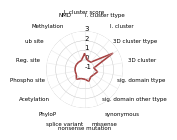

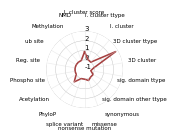

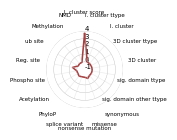

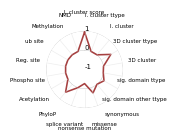

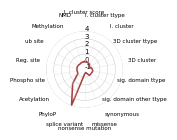

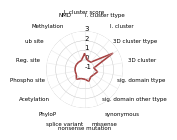

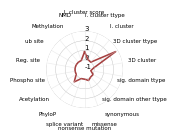

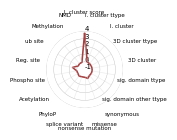

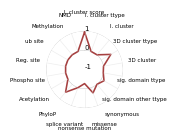

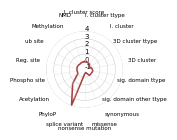

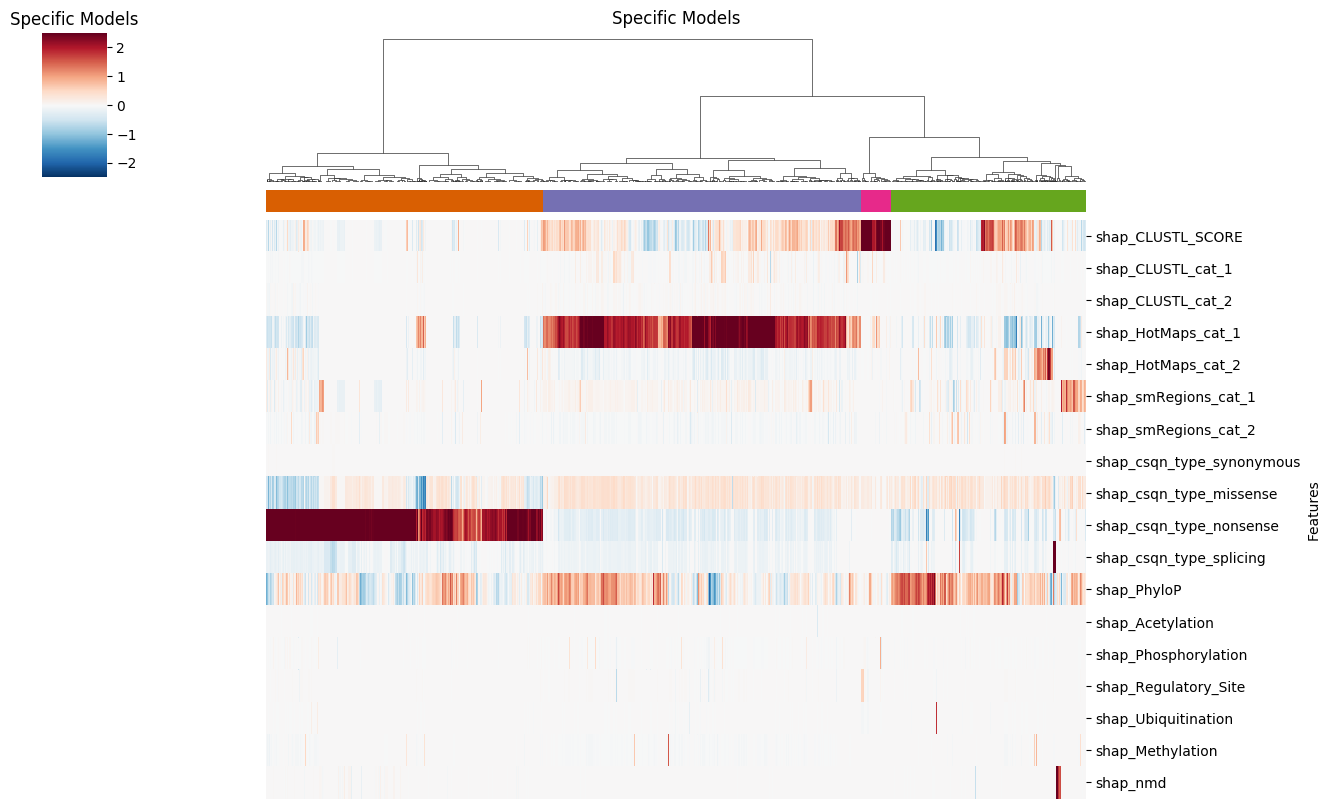

In [19]:
# unique observed mutations 
# per gene-ttype
# covered by specific models 
# with boostDM positive

labels_hierarchical = cluster_heatmap(None, None, mode='flat', 
                                      title='Specific Models', 
                                      fn='observed.specific.driver.hierarchy')

## Step 2: low rank representation

In [20]:
mutation_list = [('RB1', 'E51*', 'BLCA'), 
                 ('PIK3CA', 'E542K', 'BRCA'),
                 ('EGFR', 'L858R', 'LUAD'), 
                 ('KRAS', 'G12D', 'LUAD'), 
                 ('CTNNB1', 'S45P', 'HC'),
                 ('EGFR', 'A289D', 'GBM'),
                 ('TP53', 'K132R', 'LUSC'),
                 ('CIC', 'R202W', 'LGG')]

def index_mutations(df):
    
    zipped = list(zip(df.gene.values, df.aachange.values, df.ttype.values))    
    zipped = [None if z not in mutation_list else ':'.join(z) for z in zipped]
    return zipped
    

def tsne_projection(gene, ttype, target):
    
    df = get_shaps(mutations, None, None)
    zipped = index_mutations(df)
    
    moa_colors = df['moa'].values
    complexity_colors = df['linear_complexity'].values
    
    lowd = PCA(10).fit_transform(df[conf.features])
    tsne = manifold.TSNE(init='pca')
    embedding = tsne.fit_transform(lowd)
    return df, embedding, moa_colors, complexity_colors, zipped


def plot_tsne(projected, zipped, colors, title=None, colorbar=None, fn=None):
    
    fig, ax = plt.subplots(figsize=(5, 5))
    p = ax.scatter(list(projected[:, 0]), list(projected[:, 1]), cmap=cmap, c=colors, alpha=1, s=10)
    
    if colorbar is not None:
        cbar = fig.colorbar(p, ax=ax)
        cbar.ax.set_ylabel(colorbar, rotation=270)
    
    for i, mut in enumerate(zipped):
        if mut is not None:
            ax.text(projected[i,0], projected[i,1], mut)
            ax.scatter([projected[i, 0]], [projected[i, 1]], c='none', alpha=1, s=30, edgecolors='black')
        
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel('t-SNE1')
    ax.set_ylabel('t-SNE2')
    
    if title is not None:
        plt.title(title)
    
    if fn is not None:
        plt.savefig(fn, dpi=300)
    plt.show()

In [21]:
df, projected, moa_colors, complexity_colors, zipped = tsne_projection(None, None, labels_hierarchical)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [02:03<00:00,  2.02it/s]


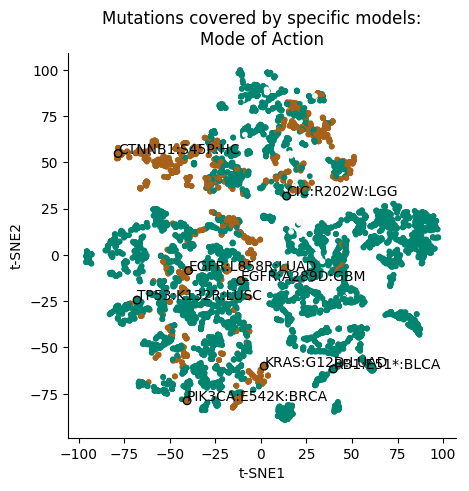

In [22]:
plot_tsne(projected, zipped, moa_colors,
          title='Mutations covered by specific models:\nMode of Action', 
          fn='./raw_plots/unique.boostdm-positive.specific.moa.png')

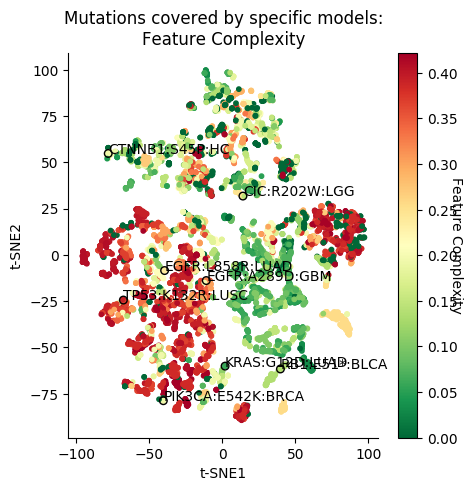

In [23]:
plot_tsne(projected, zipped, complexity_colors, colorbar='Feature Complexity',
          title='Mutations covered by specific models:\nFeature Complexity', 
          fn='./raw_plots/unique.boostdm-positive.specific.complexity.png')

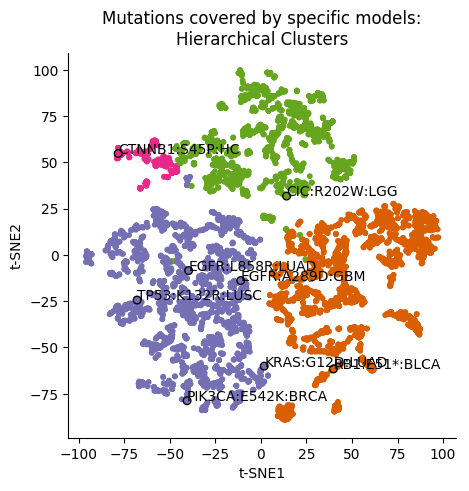

In [24]:
color_list = color_palette('Dark2', 50).as_hex()
kmeans_colors = list(map(lambda s: color_list[s], labels_hierarchical))
plot_tsne(projected, zipped, kmeans_colors, 
              title='Mutations covered by specific models:\nHierarchical Clusters', 
              fn='./raw_plots/unique.boostdm-positive.specific.hierarchical.png')